<h3>Feature Testing</h3>

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import NLP
from matplotlib import pyplot as plt
import random
import math
from sklearn import linear_model, metrics, ensemble
import pickle
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from sklearn.manifold import TSNE
from pyemd import emd
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from sklearn.decomposition import PCA


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [2]:
# connect to postgresql db
username = 'kimberly'
dbname = 'medium'

dbe = create_engine('postgres://%s@localhost/%s'%(username,dbname))

# get articles df, drop missing data
dfA = pd.read_sql('articles', dbe, index_col='postid')
dfA = dfA.dropna(axis=0,how='any')

dfS = pd.read_sql('sentences', dbe, index_col='level_0')

# add stfidf...
pkl_file = open('stfidf.pkl', 'rb')
stfidf = pickle.load(pkl_file)
pkl_file.close()
dfS['stfidf'] = stfidf

In [3]:
outlier_articles = [2298, 2399, 2454, 2607, 2808, 2992, 3167, 3283, 4590]
#dfA = dfA.drop(dfA.index[outlier_articles])
#dfA.shape

<h3>Scope down: choose only "startup" tags</h3>

In [17]:
stA = dfA[dfA.tags.str.contains('Startup')]
stS = pd.merge(dfS, stA, how='left', left_on='postid',
         left_index=False, right_index=True)
print(stS.shape)
#stS.drop(stS[stS.title.isnull()].index,inplace=True)
#print(stS.shape)

startup_sentence_bool = ~stS.title.isnull()

(434792, 21)


In [5]:
stA_index = dfA.tags.str.contains('Startup')
print(len(stA_index))
startup_index = [ax for ax,a in enumerate(stA_index) if a]
#print(startup_index)
print(len(startup_index))

stS.shape


4649
986


(95631, 21)

In [53]:
output = open('startup_index.pkl', 'wb')
pickle.dump(startup_index, output)
output.close()

<h3>Fitting the model...</h3>

First, split into true and false samples.

In [20]:
# all articles
dfS_True = dfS[dfS.slabel==True]
dfS_False = dfS[dfS.slabel==False]
index_file = 'false_indices_exactbal.pkl'

# startup articles only
dfS_True = stS[stS.slabel==True]
dfS_False = stS[stS.slabel==False]
index_file = 'false_indices_startup_exactbal.pkl'


NameError: name 'stS' is not defined

In [21]:
# all articles with raw d2vecs
dfS_True = dfS_raw[dfS_raw.slabel==True]
dfS_False = dfS_raw[dfS_raw.slabel==False]
index_file = 'false_indices_exactbal.pkl'

Downsample to have balanced data.

In [23]:
number_true = dfS_True.shape[0]

# re-regenerate or load false_indices
#false_indices = np.random.choice(dfS_False.shape[0], number_false, replace=False)

pkl_file = open(index_file, 'rb')
false_indices = pickle.load(pkl_file)
pkl_file.close()

# save false indices if desired
#output = open('false_indices_exactbal.pkl', 'wb')
#pickle.dump(false_indices, output)
#output.close()

# select samples
dfS_False_dsamp = dfS_False.iloc[false_indices]


Drop rows with missing data.

In [24]:
dfS_True = dfS_True.drop(dfS_True[dfS_True.stfidf.isnull()].index)
dfS_False_dsamp = dfS_False_dsamp.drop(dfS_False_dsamp[dfS_False_dsamp.stfidf.isnull()].index)

Split training and test data (in both false and true sets)

In [25]:
# split training and test 80/20

# training data
true_train_indices = np.random.choice(dfS_True.shape[0], 
                                      math.floor(dfS_True.shape[0]*0.8), replace=False)
false_train_indices = np.random.choice(dfS_False_dsamp.shape[0], 
                                       math.floor(dfS_False_dsamp.shape[0]*0.8), replace=False)
dfS_True_train = dfS_True.iloc[true_train_indices]
dfS_False_dsamp_train = dfS_False_dsamp.iloc[false_train_indices]
dfTrain_balanced = pd.concat([dfS_True_train,dfS_False_dsamp_train])
print(dfS_True_train.shape)
print(dfS_False_dsamp_train.shape)
print(dfTrain_balanced.shape)

# test data
true_test_indices = [x for x in range(dfS_True.shape[0]) if x not in true_train_indices]
false_test_indices = [x for x in range(dfS_False_dsamp.shape[0]) if x not in false_train_indices]
dfS_True_test = dfS_True.iloc[true_test_indices]
dfS_False_dsamp_test = dfS_False_dsamp.iloc[false_test_indices]
dfTest_balanced = pd.concat([dfS_True_test,dfS_False_dsamp_test])
print(dfS_True_test.shape)
print(dfS_False_dsamp_test.shape)
print(dfTest_balanced.shape)

(786, 108)
(776, 108)
(1562, 108)
(197, 108)
(194, 108)
(391, 108)


Set up the X and Y structures for training.

In [25]:
Ytrain = dfTrain_balanced['slabel'].astype('int')
Xtrain = dfTrain_balanced[['sposition','swcount','stfidf','alength']]
Ytest = dfTest_balanced['slabel'].astype('int')
Xtest = dfTest_balanced[['sposition','swcount','stfidf','alength']]

Train a random forest model.

In [30]:
rfm = ensemble.RandomForestClassifier(n_estimators=500, class_weight=None)
rfm.fit(Xtrain,Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Check the prediction accuracy.

In [27]:
print(rfm.score(Xtrain,Ytrain))
print(rfm.score(Xtest,Ytest))

0.999892967997
0.610183996577


Plot the predicted probabilities by class.

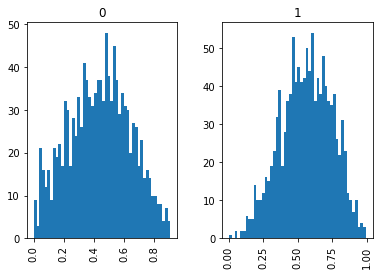

In [20]:
#rfm.predict_proba(Xtrain)
test_predix = rfm.predict_proba(Xtest)[:,1]
test_predix = pd.DataFrame(test_predix,Ytest,columns=['pred'])
test_predix.head()

plt.figure();
test_predix.hist(by=test_predix.index,bins=50)
plt.show()

Plot an ROC curve.

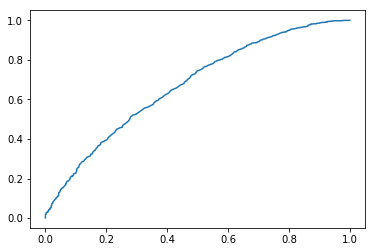

In [28]:
fpr, tpr, thresh = metrics.roc_curve(Ytest, test_predix)

plt.figure();
plt.plot(fpr,tpr)
plt.show()

<h3>Try a variation with no stf-idf</h3>

In [31]:
Xtrain2 = dfTrain_balanced[['sposition','swcount','alength']]
Xtest2 = dfTest_balanced[['sposition','swcount','alength']]
rfm2 = ensemble.RandomForestClassifier(n_estimators=500, class_weight=None)
rfm2.fit(Xtrain2,Ytrain)
print(rfm2.score(Xtrain2,Ytrain))
print(rfm2.score(Xtest2,Ytest))

0.991009311784
0.610611895593


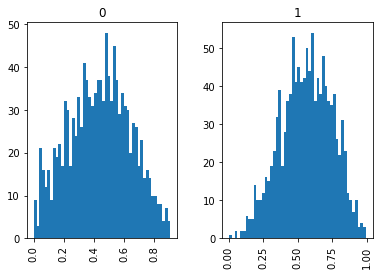

In [33]:
#rfm.predict_proba(Xtrain)
test_predix2 = rfm2.predict_proba(Xtest2)[:,1]
test_predix2 = pd.DataFrame(test_predix2,Ytest,columns=['pred'])

plt.figure();
test_predix.hist(by=test_predix2.index,bins=50)
plt.show()

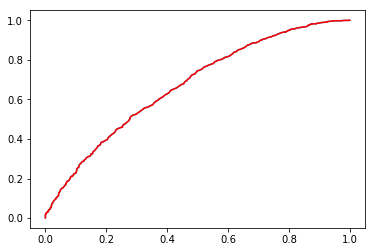

In [34]:
fpr2, tpr2, thresh2 = metrics.roc_curve(Ytest, test_predix)

plt.figure();
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2,color='r')
plt.show()

<h3>Try a variation (with startup data) that has sentence-article distance</h3>

(not enough time to compute this)

<h3>Try a variation with the raw vectors from doc2vec</h3>

Load in raw vectors...

In [ ]:
# use tsne to reduce space dimensionality 
#tsne = TSNE(n_components=10)
#d2v_tsne = tsne.fit_transform(d2v_array)

with open('d2v_tsne_nostem_10.pkl','rb') as f:
    d2v_tsne = pickle.load(f)

plt.scatter(d2v_tsne[:, 0], d2vX_tsne[:, 1])
plt.show()

<h3>This has ALL sentences...</h3>

In [18]:
dfRaw = pd.DataFrame(d2v_array,index=dfS.index)
dfS_raw = pd.concat([dfS,dfRaw],axis=1)
dfS_raw.head()

,alength,index,postid,sentence,slabel,sposition,swcount,stfidf,0,1,...,90,91,92,93,94,95,96,97,98,99
level_0,,,,,,,,,,,,,,,,,,,,,
0,52,0.0,1015a0f4961d,"{hola,desde,cuba}",False,0,3,0.707064,-0.017509,-0.031111,...,-0.000002,-0.018249,0.053595,-0.070381,0.004811,0.021985,0.034252,-0.018455,-0.018748,0.003362
1,52,0.0,1015a0f4961d,"{today,air,force,one,touched,havana,first,time...",True,1,9,0.224525,-0.016717,0.002451,...,-0.006885,-0.009163,0.023801,-0.031781,0.013973,0.015467,0.002474,-0.023497,0.000237,0.007472
2,52,0.0,1015a0f4961d,"{question,remarkable,moment,relationship,unite...",False,2,9,0.271712,0.007705,0.003216,...,-0.003051,0.006686,0.028362,0.011368,0.006327,-0.011646,-0.037562,0.009589,0.014810,0.000972
3,52,0.0,1015a0f4961d,"{also,landmark,progress,made,since,president,o...",False,3,29,0.152328,0.071163,0.046430,...,-0.047530,0.076408,-0.041447,0.056117,0.066812,-0.049130,-0.101165,-0.031418,0.047626,0.084026
4,52,0.0,1015a0f4961d,"{trip,also,professionally,personally,meaningfu...",False,4,19,0.208126,-0.005361,-0.012760,...,-0.031974,-0.014525,0.043334,-0.081592,0.034563,-0.009977,-0.074816,-0.051886,0.004417,-0.013928


In [19]:
dfS_True = dfS_raw[dfS_raw.slabel==True]
dfS_False = dfS_raw[dfS_raw.slabel==False]

In [27]:
Ytrain = dfTrain_balanced['slabel'].astype('int')
Xtrain = dfTrain_balanced[dfTrain_balanced.columns[5:]]
Ytest = dfTest_balanced['slabel'].astype('int')
Xtest = dfTest_balanced[dfTrain_balanced.columns[5:]]
rfm3 = ensemble.RandomForestClassifier(n_estimators=500, class_weight=None)
rfm3.fit(Xtrain,Ytrain)
print(rfm3.score(Xtrain,Ytrain))
print(rfm3.score(Xtest,Ytest))

1.0
0.599914420197


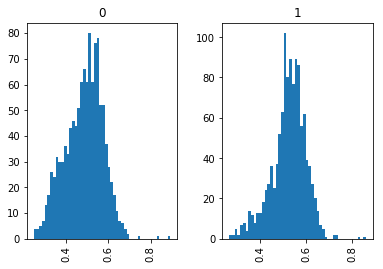

In [29]:
#rfm.predict_proba(Xtrain)
test_predix3 = rfm3.predict_proba(Xtest)[:,1]
test_predix3 = pd.DataFrame(test_predix3,Ytest,columns=['pred'])

plt.figure();
test_predix3.hist(by=test_predix3.index,bins=50)
plt.show()

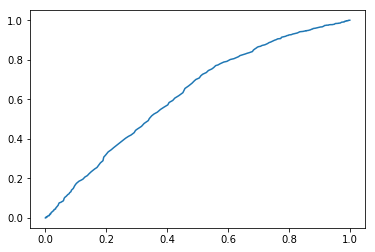

In [30]:
fpr, tpr, thresh = metrics.roc_curve(Ytest, test_predix3)

plt.figure();
plt.plot(fpr,tpr)
plt.show()

<h3>This has only startup sentences...</h3>

In [12]:
dfRaw = pd.read_csv('d2v_array_nostem.csv',index_col='level_0')

dfS_raw = pd.concat([dfS,dfRaw],axis=1)


/Users/kimberly/anaconda3/envs/insight_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [19]:
dfS_raw = dfS_raw[startup_sentence_bool]


In [22]:
dfS_True = dfS_raw[dfS_raw.slabel==True]
dfS_False = dfS_raw[dfS_raw.slabel==False]
index_file = 'false_indices_startup_exactbal.pkl'

In [27]:
Ytrain4 = dfTrain_balanced['slabel'].astype('int')
Xtrain4 = dfTrain_balanced[dfTrain_balanced.columns[5:]]
Ytest4 = dfTest_balanced['slabel'].astype('int')
Xtest4 = dfTest_balanced[dfTrain_balanced.columns[5:]]
rfm4 = ensemble.RandomForestClassifier(n_estimators=500, class_weight=None)
rfm4.fit(Xtrain4,Ytrain4)
print(rfm4.score(Xtrain4,Ytrain4))
print(rfm4.score(Xtest4,Ytest4))

1.0
0.572890025575


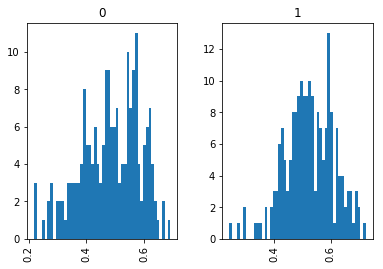

In [29]:
#rfm.predict_proba(Xtrain)
test_predix4 = rfm4.predict_proba(Xtest4)[:,1]
test_predix4 = pd.DataFrame(test_predix4,Ytest4,columns=['pred'])

plt.figure();
test_predix4.hist(by=test_predix4.index,bins=50)
plt.show()

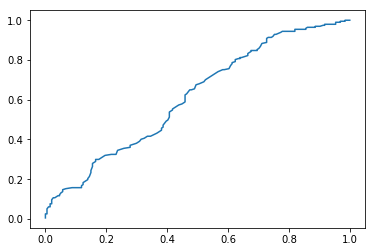

In [30]:
fpr, tpr, thresh = metrics.roc_curve(Ytest4, test_predix4)

plt.figure();
plt.plot(fpr,tpr)
plt.show()

<h3>Try with TSNE (startup only)</h3>

In [46]:
darray=dfS_raw[dfS_raw.columns[8:]].as_matrix()

In [45]:
dfS_raw.head()

,alength,index,postid,sentence,slabel,sposition,swcount,stfidf,0,1,...,90,91,92,93,94,95,96,97,98,99
level_0,,,,,,,,,,,,,,,,,,,,,
52,65,0.0,101a407e8c61,"{always,wanted,make}",False,0,3,0.510343,-0.003721,-0.009785,...,-0.002768,-0.021696,0.028166,-0.030878,-0.010796,-0.002297,0.014727,-0.016826,-0.004332,-0.003275
53,65,0.0,101a407e8c61,"{grew,dreaming,rockstar,paradigm,made,tv,sell,...",False,1,14,0.226235,0.024078,0.037127,...,0.018528,0.030478,-0.044030,0.019345,0.014759,0.003156,0.018281,-0.016034,-0.011003,-0.049786
54,65,0.0,101a407e8c61,"{paradigm,point,life,work,paid,happy}",False,2,6,0.315709,0.022598,-0.006505,...,-0.017323,0.035825,-0.011243,0.020857,0.011960,-0.015958,-0.013046,-0.008746,-0.002681,0.023449
55,65,0.0,101a407e8c61,"{everything,changes,better}",False,3,3,0.572184,-0.010775,-0.017208,...,-0.002997,-0.010120,0.039833,-0.020336,-0.019558,-0.000531,0.019089,-0.026820,-0.016351,-0.010038
56,65,0.0,101a407e8c61,"{know,idea,head,around,would,look,like,made}",False,4,8,0.307438,-0.013378,-0.004412,...,-0.000709,-0.000162,0.000908,-0.018234,-0.017911,-0.019289,0.006783,-0.013400,-0.004834,0.003892


In [47]:
darray[0]

array([-0.00372138, -0.00978515, -0.00652081, -0.02057526, -0.02817981,
        0.00629414,  0.02538642,  0.00434038, -0.01108575, -0.01279977,
        0.00551756,  0.01232911,  0.00350786, -0.00867054,  0.01439224,
       -0.01386853, -0.01776338, -0.01505521,  0.00952422, -0.00608037,
       -0.00048061, -0.01014359, -0.00888834,  0.00195773,  0.00217248,
        0.01652461, -0.00287014,  0.01980701, -0.00151752,  0.00860268,
       -0.01004052, -0.00252978, -0.03024075,  0.01159943, -0.02088038,
        0.00978513, -0.00202053,  0.00026449, -0.0060395 , -0.00400633,
       -0.00522781, -0.00091849,  0.00451551,  0.00525437,  0.00538595,
        0.01557856, -0.0126168 , -0.00132267,  0.01916108,  0.01118506,
        0.01523922, -0.0017252 ,  0.00842091,  0.00647271, -0.01439043,
       -0.00486946, -0.00773212, -0.01042981, -0.00085558, -0.00700851,
       -0.01631702,  0.0027728 ,  0.00370407, -0.00523719, -0.00244015,
        0.00010649, -0.00450861, -0.0013554 , -0.00452084,  0.02